#### Import Libraries

In [2]:
#Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

#### Import Environment

In [3]:
#Import the environment
from Env import CabDriver

#### Load the Time Matrix

In [4]:
#Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [6]:
#Defining a function to return the state as state encoding as string
def encode_state(lst):
    finaloutput=''
    for item in lst:
        if type(item)!=str:
            finaloutput+=str(int(item))
        else:
            finaloutput+=str(item)
    return finaloutput

In [7]:
#Create states tracking dictionary
States_track = collections.defaultdict(dict)

In [8]:
#Initializing with default states to be tracked
def initialise_tracking_states():
    sample_q_values = [
                   (0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0),
                   (0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0),
                   (0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0),
                   (1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1)]  
    for q_values in sample_q_values:
        state=encode_state(q_values)
        States_track[state]= []

In [9]:
#Call to initialize states tracking
initialise_tracking_states()

In [10]:
#Check the states gtracking dictionatry
States_track

defaultdict(dict,
            {'010000000000001000000000000001000000': [],
             '000100000100000000000000000000100000': [],
             '001000001000000000000000000000001000': [],
             '100000000000000000000010000000000001': []})

#### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    
    #Initializing variables and hyper-parameters
    def __init__(self, state_size, action_size):
        self.state_size = state_size       #Define size of state
        self.action_size = action_size     #Define size of action
        self.track_loss=[]                 #Tracking the loss

        #Hyper-parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.000001
        self.batch_size = 32 
        self.memory = deque(maxlen=2000)   #Replay memory using deque
        self.model = self.build_model()    #Main model and target model

        
    #Defining approximate Q function using Neural Network
    def build_model(self):
        
        #Define sequential model
        model = Sequential()    
      
        #Set the hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        #Set the output layer: size = num_actions in this case 20
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        
        #Compile model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    #Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            
            #Random sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))

            actions, rewards, done = [], [],[]
            
            #Loop throught each data point in the batch
            for i in range(self.batch_size):
                state, action, reward, next_state,done_boolean = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            #Predict the target from earlier model
            target = self.model.predict(update_input)

            #Get the target for the Q-network
            target_qval = self.model.predict(update_output)
        
            #Updating 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: 
                    # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i]) #DQ formula
          
                #Saving the Q values for states tracked
                state_key=encode_state(update_input[i])
                if state_key in States_track.keys():
                    States_track[state_key].append(target[i])
        
            #Fitting the model and tracking the loss values
            history=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            self.track_loss.append(history.history['loss'])


    #Getthe model weights
    def get_model_weights(self):
        return self.model.get_weights()
    
    #Deduce the action either by exploration or exploitation
    def get_action(self, state,request_actions):
      # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon_max:   # Decay in ε after we generate each sample from the environment
            return request_actions[random.randrange(len(request_actions))]
        else:
          # choose the action with the highest q(s, a)
          # the first index corresponds to the batch size, so
          # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value)    

    #Save sample <s,a,r,s',done> to the replay memory
    def append_sample(self, state, action, reward, next_state,done):
        self.memory.append((state, action, reward, next_state,done))    
        
        
    #Save the model
    def save(self ,name):
        self.model.save(name)

In [12]:
#Define the episodes
Episodes=15000

#Set the environment
env=CabDriver()

#Call the DQN agent and compute rewards
agent=DQNAgent(state_size=env.state_size,action_size=env.action_size)
rewards_per_episode, episodes = [], []

#### DQN block

In [13]:
#Loop through each episode
import time
start_time = time.time()

for episode in range(Episodes):
    terminal_state=False
    score=0
    env_initalized=env.reset()
    state=env_initalized[2]
    
    while not terminal_state:
        request_actions=env.requests(state)
        next_action=agent.get_action(env.state_encod_arch1(state),request_actions) 
        next_state,action,reward,is_done=env.next_state_func(state,next_action,Time_matrix)
        if action[0]!=0 and action[1]!=0:
            agent.append_sample(env.state_encod_arch1(state),env.action_space.index(action),reward,env.state_encod_arch1(next_state),is_done)
            
            #Train the model by calling function agent.train_model
            agent.train_model()
            
            #Keep a track of rewards, Q-values, loss
            score+=reward
        
        #Assinging state with next_state
        state=next_state
        terminal_state=is_done
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    #Update the epsilon value for action selection
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max=agent.epsilon_min+(agent.epsilon_max-agent.epsilon_min)*np.exp(-0.000001*episode)
    
    #Save the model
    if (episode+1) %1000 == 0:
        save_obj(agent.get_model_weights(), 'weights_per_'+str(episode+1)+'_epiosde')
        agent.save(name="SuperCabs_DQN_model.h5")
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,score,len(agent.memory),agent.epsilon_max))

episode 999, reward 57.0, memory_length 2000, epsilon 0.6068343940374606
episode 1999, reward 5408.0, memory_length 2000, epsilon 0.13547155073936643
episode 2999, reward 6305.0, memory_length 2000, epsilon 0.011126661411249421
episode 3999, reward 6265.0, memory_length 2000, epsilon 0.0003371338883968558
episode 4999, reward 6334.0, memory_length 2000, epsilon 4.735977724529479e-06
episode 5999, reward 6334.0, memory_length 2000, epsilon 1.0152757230117051e-06
episode 6999, reward 6334.0, memory_length 2000, epsilon 1.0000229776066086e-06
episode 7999, reward 6334.0, memory_length 2000, epsilon 1.0000000127149113e-06
episode 8999, reward 6334.0, memory_length 2000, epsilon 1.0000000000025885e-06
episode 9999, reward 6334.0, memory_length 2000, epsilon 1.0000000000000105e-06
episode 10999, reward 6334.0, memory_length 2000, epsilon 1.0000000000000095e-06
episode 11999, reward 6334.0, memory_length 2000, epsilon 1.0000000000000086e-06
episode 12999, reward 6334.0, memory_length 2000, ep

In [14]:
#Compute time taken for execution
elapsed_time = time.time() - start_time
print('Total execution time', round((elapsed_time/60),0), 'Minutes.')

Total execution time 189.0 Minutes.


In [15]:
#Save the rewards
save_obj(rewards_per_episode,"rewards_final")

In [16]:
#Save the states tracked
save_obj(States_track,"States Tracked")
state_keys=list(States_track.keys())

#### Tracking Convergence

In [17]:
#Load the rewards file to check convergence
with open('rewards_final.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

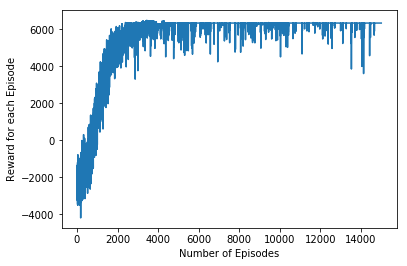

In [18]:
#Plot the convergence
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for each Episode")
#plt.yscale('log')
plt.show()

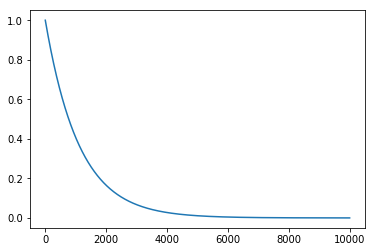

In [19]:
#Sample epsilon decay expression
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

plt.plot(time, epsilon)
plt.show()    